### Imports

In [37]:
from IPython.display import clear_output
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import string
from colorama import Fore, Back, Style
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [38]:
!pip install scikit-learn-intelex
clear_output()

In [39]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [40]:
!pip install catboost
!pip install nltk
!pip install scikit-learn
!pip install sentence-transformers

clear_output()

In [41]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/udb8ca7cfe0f27bea15b16def2ddc1b1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/udb8ca7cfe0f27bea15b16def2ddc1b1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Reading data

In [42]:
import pandas as pd
data = pd.read_csv('text_des_domestic.csv')

In [43]:
data.head()

,Description,Label
0,My partner got really mad last night and start...,physical
1,I've been going through physical abuse for a f...,physical
2,There's a pattern of violence in my relationsh...,physical
3,I have injuries on my arms and legs from the a...,physical
4,My partner has been hitting me during argument...,physical


### Data Preprocessing

In [44]:
stop_words = set(stopwords.words('english'))


In [45]:
# preprocessing functions

lemma = WordNetLemmatizer()

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text= re.sub('<.*?>', ' ', text)
    return text


def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]

    tokens = [lemma.lemmatize(word) for word in dropped]

    final_text = ' '.join(tokens)
    return final_text

# applying preprocessing functions
data_processed = data.copy()
data_processed['Description'] = data_processed['Description'].apply(text_preprocessing).apply(drop_stopwords)


In [46]:
# label encoding
LE = LabelEncoder()
data_processed['encoded_label'] = LE.fit_transform(data_processed['Label'])

In [47]:
# a function for calculating and plotting predictions
def plot_prediction_results(model, X_data, y_data, target_names = list(LE.classes_)):
    pred = model.predict(X_data)

    mse = mean_squared_error(y_data, pred)
    f1 = f1_score(y_data, pred, average = 'weighted')
    acc = accuracy_score(y_data, pred)
    cm = confusion_matrix(y_data, pred)

    clf = classification_report(y_data, pred, target_names = target_names)

    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)

    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay(cm, display_labels = target_names)
    fig, axs = plt.subplots(figsize=(4,4))
    cmd.plot(ax=axs, cmap="bone", xticks_rotation="vertical", colorbar = False)

In [48]:
data_processed.shape

(148, 3)

In [49]:
# data after preprocessing operations
data_processed.head()

,Description,Label,encoded_label
0,partner got really mad last night started yell...,physical,3
1,going physical abuse week partner hold hit bel...,physical,3
2,pattern violence relationship partner push sho...,physical,3
3,injury arm leg abuse partner us force control ...,physical,3
4,partner hitting argument visible injury living...,physical,3


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

In [51]:
emmedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
SEED = 32

### Train test split

In [52]:
# train and test splitting
from sklearn.model_selection import train_test_split

type_train_data, type_test_data = train_test_split(data_processed, test_size = 0.2, random_state = SEED, shuffle = True)
type_train_data = type_train_data.reset_index(drop = True)
type_test_data = type_test_data.reset_index(drop = True)

print('train sample size\t', type_train_data.shape[0])
print('test sample size\t', type_test_data.shape[0])

train sample size	 118
test sample size	 30


In [53]:
train_embeddings = emmedding_model.encode(list(type_train_data['Description'].values), show_progress_bar = True)
test_embeddings = emmedding_model.encode(list(type_test_data['Description'].values), show_progress_bar = True)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

### Using oneDAL for PCA

In [54]:
%%time
from sklearnex.decomposition import PCA
pca= PCA(n_components=30)
train_pca = pca.fit_transform(train_embeddings)
test_pca = pca.transform(test_embeddings)
print('\nbefore PCA, train feature size\t', train_embeddings.shape[1])
print('\nafter PCA, train feature size\t', train_pca.shape[1])


before PCA, train feature size	 384

after PCA, train feature size	 30
CPU times: user 431 ms, sys: 561 ms, total: 992 ms
Wall time: 13.1 ms


In [55]:
%%time
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
train_pca_ = pca.fit_transform(train_embeddings)
test_pca_ = pca.transform(test_embeddings)

CPU times: user 257 ms, sys: 394 ms, total: 651 ms
Wall time: 10.2 ms


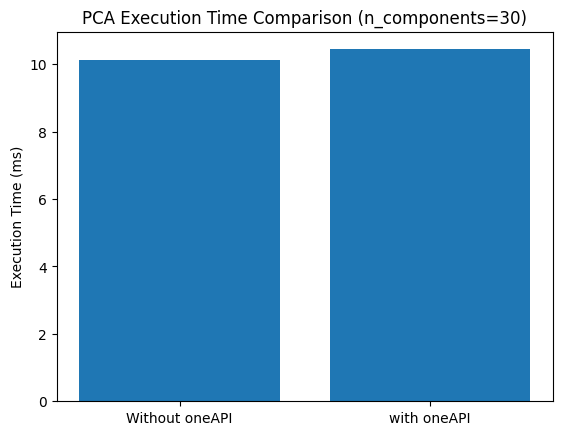

In [56]:
import time
import matplotlib.pyplot as plt
n_components = 30

# without Using oneAPI
start_time= time.time()
pca_normal= PCA(n_components=n_components)
train_pca_normal= pca_normal.fit_transform(train_embeddings)
test_pca_normal = pca_normal.transform(test_embeddings)
normal_execution_time = (time.time() - start_time) * 1000  # Convert to milliseconds


# Using oneAPI
start_time_onedal = time.time()
pca_onedal = PCA(n_components=n_components)
train_pca_onedal = pca_onedal.fit_transform(train_embeddings)
test_pca_onedal = pca_onedal.transform(test_embeddings)
onedal_execution_time = (time.time() - start_time_onedal) * 1000  # Convert to milliseconds

# Plotting the comparison graph
labels = ['Without oneAPI', 'with oneAPI']
execution_times = [normal_execution_time, onedal_execution_time]

plt.bar(labels, execution_times)
plt.ylabel('Execution Time (ms)')
plt.title(f'PCA Execution Time Comparison (n_components={n_components})')
plt.show()


In [57]:
X_train_pca = train_pca
y_train = type_train_data['encoded_label']

X_test_pca = test_pca
y_test = type_test_data['encoded_label']


## Model 1: catboost classifier

In [58]:
%%time
# a tuned model
cat_model = CatBoostClassifier(verbose = 500)

# training
cat_model.fit(X_train_pca, y_train)

Learning rate set to 0.070956
0:	learn: 1.9179640	total: 6.57ms	remaining: 6.56s
500:	learn: 0.0429313	total: 1.21s	remaining: 1.2s
999:	learn: 0.0181866	total: 2.38s	remaining: 0us
CPU times: user 6min 58s, sys: 21 s, total: 7min 19s
Wall time: 2.49 s


Mean Squared Error :	1.66667
Weighted F1 Score :	0.942
Accuracy Score :	93.333 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

    cultural       1.00      1.00      1.00         6
   emotional       1.00      0.60      0.75         5
   isolation       1.00      1.00      1.00         3
    physical       1.00      1.00      1.00         9
      sexual       1.00      1.00      1.00         3
    stalking       1.00      1.00      1.00         3
      verbal       0.33      1.00      0.50         1

    accuracy                           0.93        30
   macro avg       0.90      0.94      0.89        30
weighted avg       0.98      0.93      0.94        30

----------------------------------------------------------------------

 Confusion Matrix: 



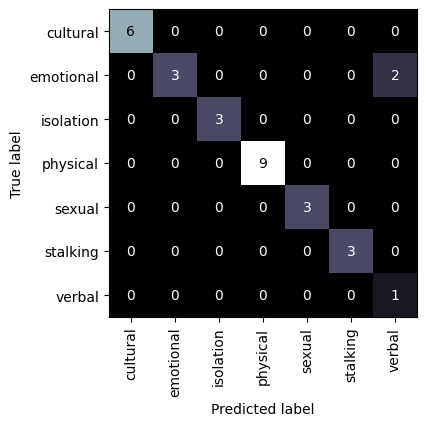

In [59]:
plot_prediction_results(cat_model, X_test_pca, y_test)

## Model 2: Logistic regression

### Using oneDAL for Logistic regression

In [60]:

%%time
from sklearnex.linear_model import LogisticRegression

log_reg_intel = make_pipeline(TfidfVectorizer(), LogisticRegression(C=2.0, max_iter = 500))
log_reg_intel.fit(type_train_data['Description'].values, y_train)

CPU times: user 15.7 ms, sys: 4.86 ms, total: 20.5 ms
Wall time: 6.81 ms


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=2.0, max_iter=500))])

In [61]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

log_reg = make_pipeline(TfidfVectorizer(), SklearnLogisticRegression(C=2.0, max_iter = 500))
log_reg.fit(type_train_data['Description'].values, y_train)

CPU times: user 5.96 ms, sys: 8.25 ms, total: 14.2 ms
Wall time: 4.74 ms


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=2.0, max_iter=500))])

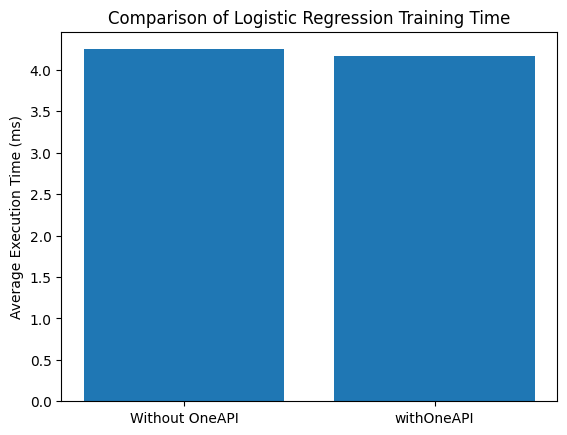

In [62]:
import time
import matplotlib.pyplot as plt
from sklearnex.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

log_reg_sklearnex = make_pipeline(TfidfVectorizer(), LogisticRegression(C=2.0, max_iter=500))
log_reg_sklearn = make_pipeline(TfidfVectorizer(), SklearnLogisticRegression(C=2.0, max_iter=500))

# Function to measure execution time
def measure_time(model, data):
    start_time = time.time()
    model.fit(data['Description'].values, y_train)
    return (time.time() - start_time) * 1000  # Convert to milliseconds

# Measure execution times
sklearnex_time = [measure_time(log_reg_sklearnex, type_train_data) for _ in range(10)]
sklearn_time = [measure_time(log_reg_sklearn, type_train_data) for _ in range(10)]

# Plot the comparison graph
labels = ['Without OneAPI', 'withOneAPI']
times = [sum(sklearnex_time) / len(sklearnex_time), sum(sklearn_time) / len(sklearn_time)]

plt.bar(labels, times)
plt.ylabel('Average Execution Time (ms)')
plt.title('Comparison of Logistic Regression Training Time')
plt.show()


### Ensemble Model


In [63]:
# prediction probabilities
pred_proba1 = cat_model.predict_proba(X_test_pca)
pred_proba2 = log_reg.predict_proba(type_test_data['Description'].values)

In [64]:
# final ensemble predictions
# 32% CatBoostClassifier + 68% Logistic Regression

final_test_pred_ = (pred_proba1*0.32 + pred_proba2*0.68)
final_test_pred = np.argmax(final_test_pred_, axis = 1)

In [65]:
mse = mean_squared_error(y_test, final_test_pred)
f1 = f1_score(y_test, final_test_pred, average = 'weighted')
acc = accuracy_score(y_test, final_test_pred)
cm = confusion_matrix(y_test, final_test_pred)

clf = classification_report(y_test, final_test_pred, target_names = list(LE.classes_))

print('Mean Squared Error :\t{0:.5f}'.format(mse))
print('Weighted F1 Score :\t{0:.3f}'.format(f1))
print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
print('--'*35)

print('\n Classification Report:\n',clf)
print('--'*35)

Mean Squared Error :	1.70000
Weighted F1 Score :	0.906
Accuracy Score :	90.000 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

    cultural       1.00      1.00      1.00         6
   emotional       1.00      0.60      0.75         5
   isolation       1.00      1.00      1.00         3
    physical       0.90      1.00      0.95         9
      sexual       1.00      0.67      0.80         3
    stalking       1.00      1.00      1.00         3
      verbal       0.33      1.00      0.50         1

    accuracy                           0.90        30
   macro avg       0.89      0.90      0.86        30
weighted avg       0.95      0.90      0.91        30

----------------------------------------------------------------------


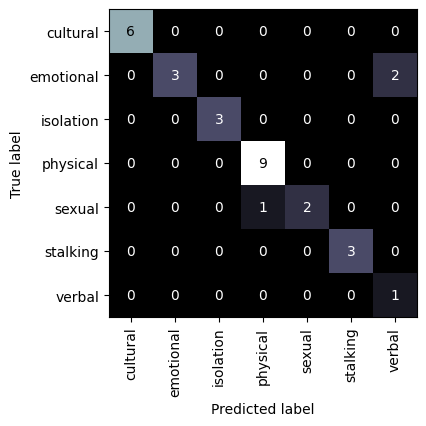

In [66]:
# confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels = list(LE.classes_))
fig, axs = plt.subplots(figsize=(4,4))
cmd.plot(ax=axs, cmap="bone", xticks_rotation="vertical", colorbar = False)

## Classifying new input

In [67]:
new_data = ["My partner got really angry last night and started shouting. They hit me in the face a lot, and now I have bruises and a swollen eye."]
new_data_processed = [text_preprocessing(text) for text in new_data]
new_data_processed = [drop_stopwords(text) for text in new_data_processed]


In [68]:
# Predict with Logistic Regression

new_pred_log_reg = log_reg.predict(new_data_processed)

# Output prediction
print("Predicted Label:", LE.inverse_transform(new_pred_log_reg)[0])


Predicted Label: physical


In [69]:
new_data_embeddings = emmedding_model.encode(new_data)
new_data_pca = pca.transform(new_data_embeddings)

In [70]:
pred_proba1 = cat_model.predict_proba(new_data_pca)
pred_proba2 = log_reg.predict_proba(new_data_processed)
final_pred_proba = (pred_proba1 * 0.32) + (pred_proba2 * 0.68)
final_predictions = np.argmax(final_pred_proba, axis=1)


In [71]:
predicted_class = LE.inverse_transform(final_predictions)[0]
print("Predicted class:", predicted_class)


Predicted class: physical


### Exporting pickle file

In [72]:
import pickle

with open('cat_model.pkl', 'wb') as cat_model_file:
    pickle.dump(cat_model, cat_model_file)

with open('log_reg_model.pkl', 'wb') as log_reg_model_file:
    pickle.dump(log_reg, log_reg_model_file)

weights = {'cat_model_weight': 0.32, 'log_reg_weight': 0.68}

with open('ensemble_weights.pkl', 'wb') as weights_file:
    pickle.dump(weights, weights_file)

pred_proba1 = cat_model.predict_proba(X_test_pca)
pred_proba2 = log_reg.predict_proba(type_test_data['Description'].values)
final_test_pred_ = (pred_proba1 * weights['cat_model_weight'] + pred_proba2 * weights['log_reg_weight'])

with open('ensemble_predictions.pkl', 'wb') as ensemble_pred_file:
    pickle.dump(final_test_pred_, ensemble_pred_file)
